In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

In [4]:
class knn():
    def fit(self, xtrain, ytrain, k, tree=True):
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.k = k
        self.tree = tree
        self.correct = 0
        
    def dist(self, a, b):
        return np.linalg.norm(a-b)
    
    def closest(self, row, k):
        best_dist = self.dist(row, self.xtrain[0])
        best_indx = 0
        
        for i in range(self.k, len(self.xtrain)):
            dist = self.dist(row, self.xtrain[i])
            if dist < best_dist:
                best_dist = dist
                best_indx = i
            #if i % 100 == 0:
                #print("Iteration ", i)
        #print(self.ytrain[best_indx])
        return self.ytrain[best_indx]
    
    def predictKD(self, xtest, k):
        self.predictions = []
        self.kdtree = KDTree(self.xtrain, leaf_size=40)
        dist, ind = self.kdtree.query(xtest, k=self.k)
        self.predictions = self.ytrain[ind[:,0]]
        self.predictions = np.squeeze(self.predictions)
        return self.predictions        
        
    def predict(self, xtest, k):
        self.predictions = []
        for row in xtest:
            label = self.closest(row, k)
            self.predictions.append(label)
        return self.predictions
    
    def accuracy_score(self, ytrue):
        self.correct = 0
        for i in range(len(ytrue)):
            if ytrue[i] == self.predictions[i]:
                self.orrect += 1
        return (self.correct/float(len(ytrue))) * 100.0
    
    def get_results(self, ylabel):
        self.ylabel = ylabel
        size = len(self.ylabel)
        conf = confusion_matrix(self.ylabel, self.predictions)
        plt.figure(0).clf()
        plt.imshow(conf)
        print(classification_report(self.ylabel, self.predictions))
        fpr = (len(ylabel) - self.correct) // len(ylabel)
        tpr = self.correct // len(ylabel)
        plt.figure(1).clf()
        plt.scatter([fpr], [tpr], marker='o', label='KNN ROC point')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.show()

In [5]:
def main(csvX, csvY, k, test_size=0.8):
    dfA = pd.read_csv(csvX)
    dfy = pd.read_csv(csvY)
    dfA = dfA[1:]
       
    names = dfA.columns 
    if 'domain1' in names:
        dfA = dfA.drop(columns=['domain1'])
        dfA = dfA.drop(columns=['state1'])
    else:
        dfA = dfA.drop(columns=['state1'])
        dfA = dfA.drop(columns=['custAttr2'])
 
    dfA = pd.get_dummies(dfA)
    
    X = np.array(dfA)
    y = np.array(dfy)
    pca = PCA(n_components=17)
    pca_vals = pca.fit_transform(X)
    V = pca.components_
    pca_X = np.matmul(X, V[:6, :].T)   
    scaler = StandardScaler()        
    pca_X = scaler.fit_transform(pca_X)

    mask = np.random.rand(len(X)) < test_size
    
    idx = np.random.permutation(list(range(X.shape[0])))
    if pca:
        pca_X = pca_X[idx, :]
        y = y[idx]
        trX = pca_X[mask]
        testX = pca_X[~mask]
        trY = y[mask]
        testY = y[~mask] 
    else:
        X = X[idx, :]
        y = y[idx]
        trX = X[mask]
        testX = X[~mask]
        trY = y[mask]
        testY = y[~mask] 
    
    ###### 3.1 ###### 10 Random 80-20 splits for odd k from 3-23
    if test_size == 0.9:
        classifier = knn()
        classifier.fit(trX, trY, k)
        train_preds = classifier.predictKD(trX, k)
        print("For k value, ", k, ": ", accuracy_score(trY, train_preds)*100, "\tTrain Set")
        
        predictions = classifier.predictKD(testX, k)   
        print("For k value, ", k, ": ", accuracy_score(testY, predictions)*100, "\tTest Set")
        classifier.get_results(testY)
    
    ###### 3.2 and 3.3 ######
    else:
        classifier = knn()
        classifier.fit(trX, trY, k)
        train_preds = classifier.predictKD(trX, k)
        print("For k value, ", k, ": ", accuracy_score(trY, train_preds)*100, "\tTrain Set")
        classifier.get_results(trY)
        
        predictions = classifier.predictKD(testX, k)   
        print("For k value, ", k, ": ", accuracy_score(testY, predictions)*100, "\tTest Set")
        classifier.get_results(testY)

For k value,  3 :  99.9590000702856 	Train Set
For k value,  3 :  97.0907139023081 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9112
           1       0.31      0.28      0.29       203

   micro avg       0.97      0.97      0.97      9315
   macro avg       0.65      0.63      0.64      9315
weighted avg       0.97      0.97      0.97      9315



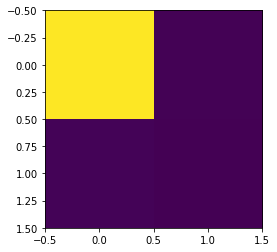

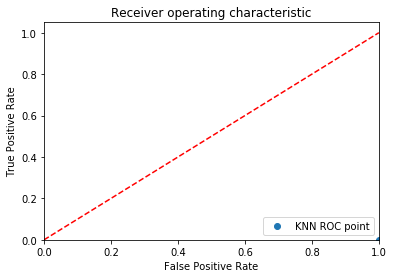

For k value,  3 :  99.89094267813623 	Train Set
For k value,  3 :  96.35036496350365 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9843
           1       0.36      0.33      0.34       295

   micro avg       0.96      0.96      0.96     10138
   macro avg       0.67      0.66      0.66     10138
weighted avg       0.96      0.96      0.96     10138



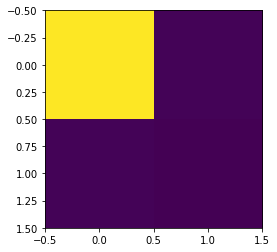

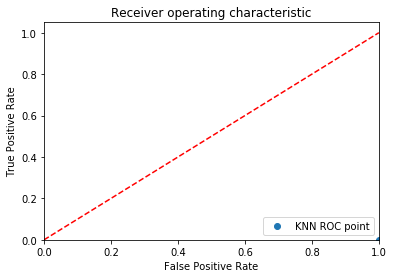

For k value,  5 :  99.95656257337403 	Train Set
For k value,  5 :  96.76876118303338 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9296
           1       0.27      0.28      0.27       205

   micro avg       0.97      0.97      0.97      9501
   macro avg       0.63      0.63      0.63      9501
weighted avg       0.97      0.97      0.97      9501



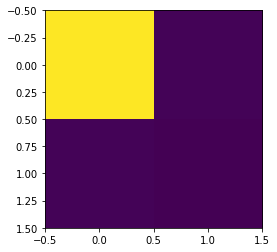

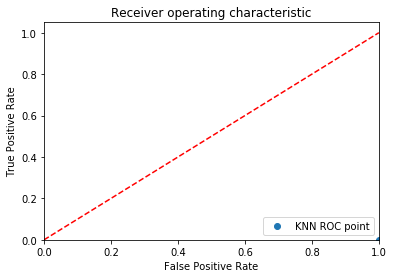

For k value,  5 :  99.90330862331484 	Train Set
For k value,  5 :  96.66733186988625 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9771
           1       0.35      0.38      0.36       251

   micro avg       0.97      0.97      0.97     10022
   macro avg       0.67      0.68      0.67     10022
weighted avg       0.97      0.97      0.97     10022



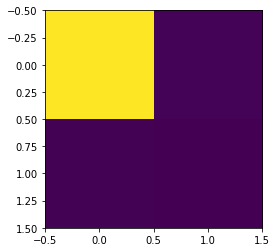

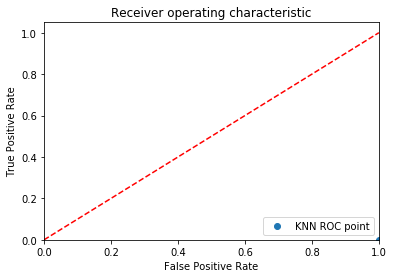

For k value,  7 :  99.96364190797884 	Train Set
For k value,  7 :  96.84646421745595 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      9202
           1       0.29      0.25      0.27       216

   micro avg       0.97      0.97      0.97      9418
   macro avg       0.64      0.62      0.63      9418
weighted avg       0.97      0.97      0.97      9418



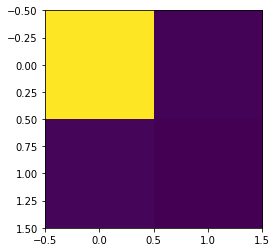

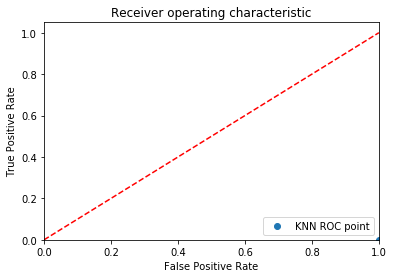

For k value,  7 :  99.89335347767644 	Train Set
For k value,  7 :  96.8142656782208 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9735
           1       0.36      0.36      0.36       247

   micro avg       0.97      0.97      0.97      9982
   macro avg       0.67      0.67      0.67      9982
weighted avg       0.97      0.97      0.97      9982



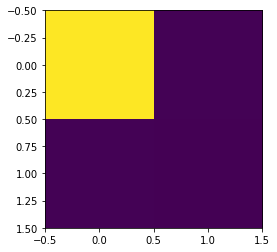

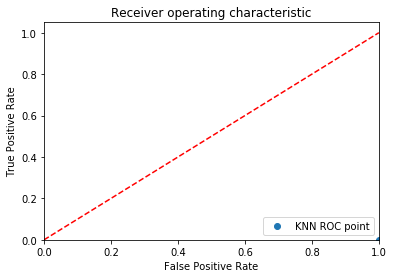

For k value,  9 :  99.9601686972821 	Train Set
For k value,  9 :  96.62053427743804 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9115
           1       0.24      0.25      0.25       206

   micro avg       0.97      0.97      0.97      9321
   macro avg       0.61      0.62      0.62      9321
weighted avg       0.97      0.97      0.97      9321



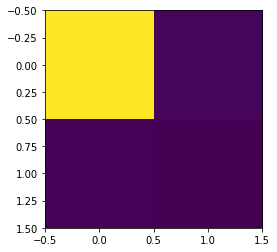

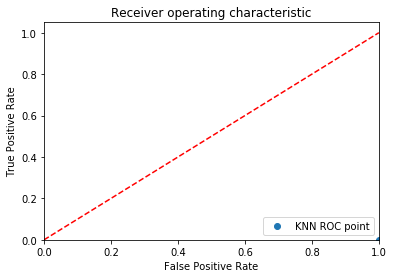

For k value,  9 :  99.88884319108968 	Train Set
For k value,  9 :  96.81147867676366 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9788
           1       0.36      0.37      0.36       248

   micro avg       0.97      0.97      0.97     10036
   macro avg       0.67      0.68      0.67     10036
weighted avg       0.97      0.97      0.97     10036



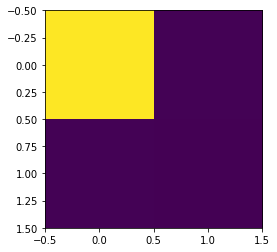

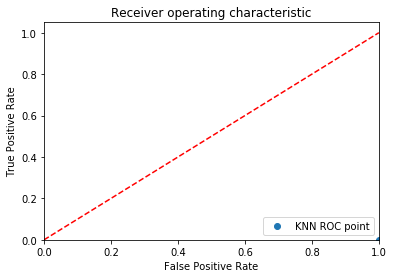

For k value,  11 :  99.95767245535032 	Train Set
For k value,  11 :  96.86396677050882 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      9412
           1       0.29      0.26      0.27       218

   micro avg       0.97      0.97      0.97      9630
   macro avg       0.64      0.62      0.63      9630
weighted avg       0.97      0.97      0.97      9630



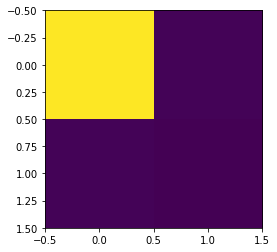

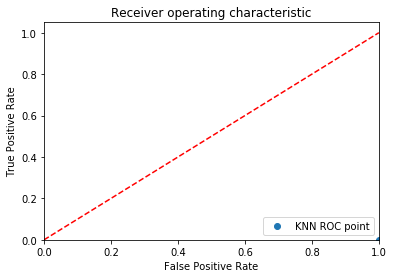

For k value,  11 :  99.90008880994672 	Train Set
For k value,  11 :  96.36052021373122 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9653
           1       0.35      0.40      0.37       266

   micro avg       0.96      0.96      0.96      9919
   macro avg       0.66      0.69      0.68      9919
weighted avg       0.97      0.96      0.96      9919



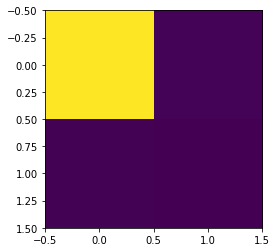

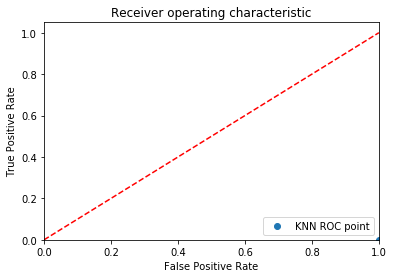

For k value,  13 :  99.96004183854552 	Train Set
For k value,  13 :  96.66388657214345 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9374
           1       0.27      0.28      0.28       218

   micro avg       0.97      0.97      0.97      9592
   macro avg       0.63      0.63      0.63      9592
weighted avg       0.97      0.97      0.97      9592



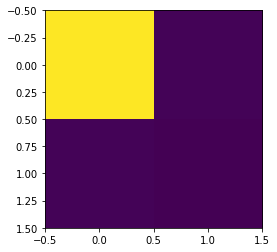

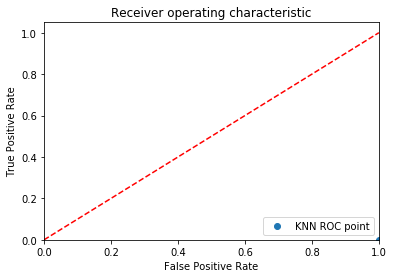

For k value,  13 :  99.88981513428085 	Train Set
For k value,  13 :  96.73891625615764 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9894
           1       0.37      0.41      0.39       256

   micro avg       0.97      0.97      0.97     10150
   macro avg       0.68      0.69      0.68     10150
weighted avg       0.97      0.97      0.97     10150



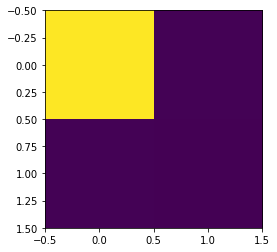

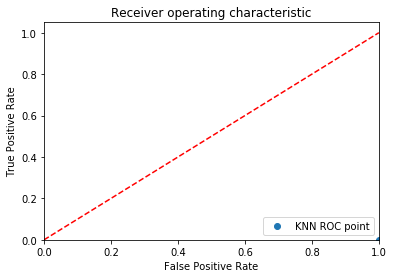

For k value,  15 :  99.96012291524946 	Train Set
For k value,  15 :  96.7300138018898 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9194
           1       0.31      0.30      0.31       225

   micro avg       0.97      0.97      0.97      9419
   macro avg       0.65      0.64      0.64      9419
weighted avg       0.97      0.97      0.97      9419



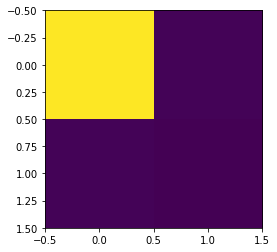

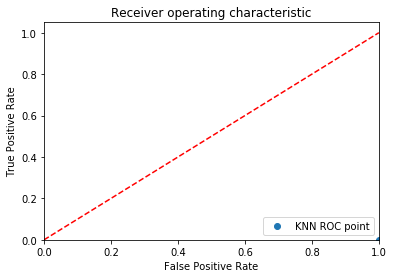

For k value,  15 :  99.88901713575424 	Train Set
For k value,  15 :  96.78625568468924 	Test Set
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      9658
           1       0.35      0.40      0.37       237

   micro avg       0.97      0.97      0.97      9895
   macro avg       0.67      0.69      0.68      9895
weighted avg       0.97      0.97      0.97      9895



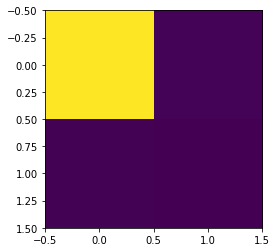

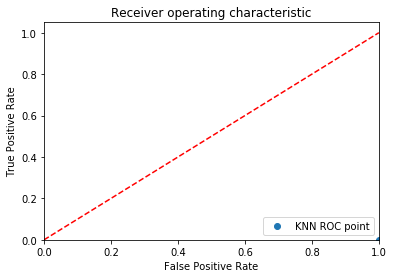

For k value,  17 :  99.96360434399764 	Train Set
For k value,  17 :  97.02293288449401 	Test Set
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      9305
           1       0.30      0.31      0.30       201

   micro avg       0.97      0.97      0.97      9506
   macro avg       0.64      0.65      0.64      9506
weighted avg       0.97      0.97      0.97      9506



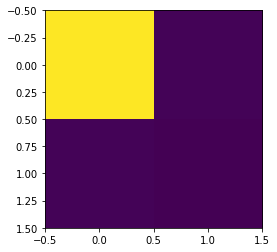

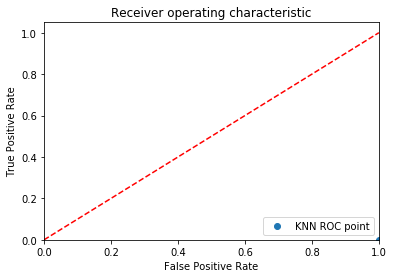

For k value,  17 :  99.8911365125915 	Train Set
For k value,  17 :  96.91320905993184 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9733
           1       0.37      0.36      0.36       245

   micro avg       0.97      0.97      0.97      9978
   macro avg       0.68      0.67      0.67      9978
weighted avg       0.97      0.97      0.97      9978



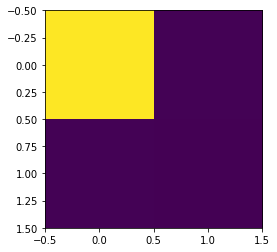

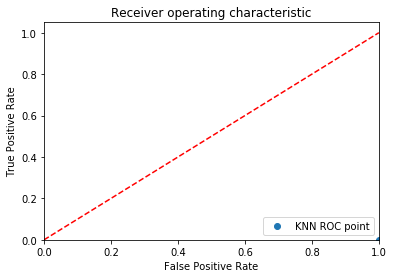

For k value,  19 :  99.96596124276677 	Train Set
For k value,  19 :  96.7840573597638 	Test Set
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      9290
           1       0.26      0.30      0.28       194

   micro avg       0.97      0.97      0.97      9484
   macro avg       0.62      0.64      0.63      9484
weighted avg       0.97      0.97      0.97      9484



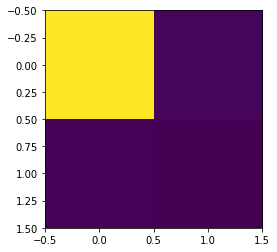

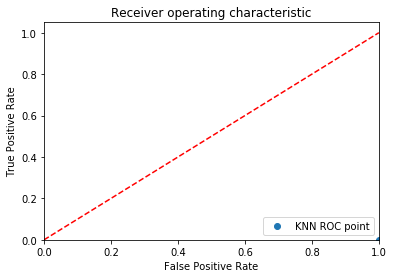

For k value,  19 :  99.89112441812668 	Train Set
For k value,  19 :  96.63596315578694 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9723
           1       0.36      0.35      0.35       265

   micro avg       0.97      0.97      0.97      9988
   macro avg       0.67      0.67      0.67      9988
weighted avg       0.97      0.97      0.97      9988



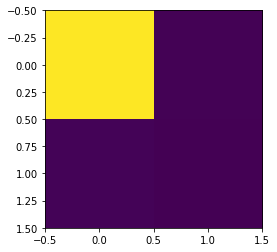

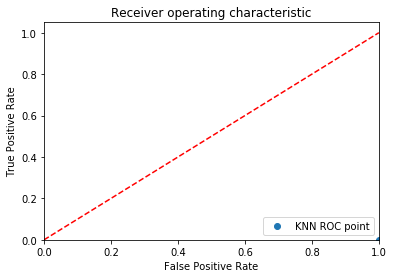

For k value,  21 :  99.96479203830626 	Train Set
For k value,  21 :  96.78032302332946 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9262
           1       0.27      0.25      0.26       211

   micro avg       0.97      0.97      0.97      9473
   macro avg       0.62      0.62      0.62      9473
weighted avg       0.97      0.97      0.97      9473



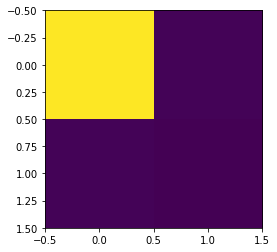

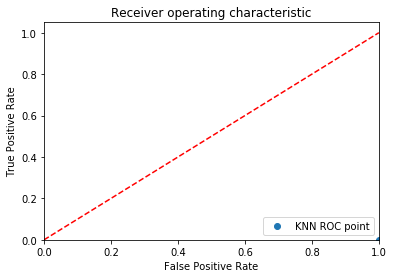

For k value,  21 :  99.89419992872416 	Train Set
For k value,  21 :  96.87469383756245 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9948
           1       0.39      0.40      0.39       259

   micro avg       0.97      0.97      0.97     10207
   macro avg       0.69      0.69      0.69     10207
weighted avg       0.97      0.97      0.97     10207



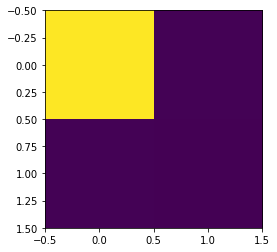

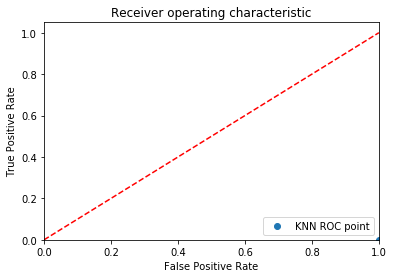

In [6]:
###### Task 3.1 10-fold Cross Validation for odd k ranging from 3-23 ######
plt.ion()
for k in range(3, 23, 2):
    main(os.path.join(os.getcwd(), "Set-A.X.csv"),os.path.join(os.getcwd(), "Set-A.y.csv"), k, test_size=0.9)
    main(os.path.join(os.getcwd(), "Set-B.X.csv"),os.path.join(os.getcwd(), "Set-B.y.csv"), k, test_size=0.9)

For k value,  5 :  99.95645978467384 	Train Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74113
           1       0.99      0.99      0.99      1679

   micro avg       1.00      1.00      1.00     75792
   macro avg       1.00      0.99      0.99     75792
weighted avg       1.00      1.00      1.00     75792



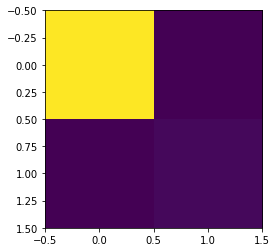

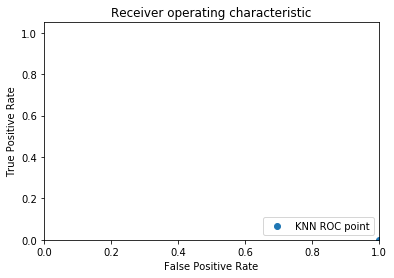

For k value,  5 :  96.67001958812007 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18474
           1       0.26      0.27      0.26       415

   micro avg       0.97      0.97      0.97     18889
   macro avg       0.62      0.63      0.62     18889
weighted avg       0.97      0.97      0.97     18889



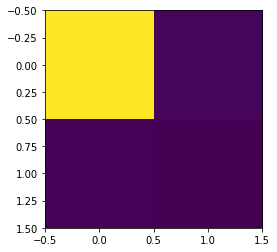

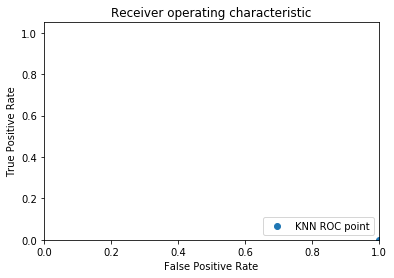

For k value,  5 :  99.90754276147283 	Train Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     77904
           1       0.98      0.98      0.98      2133

   micro avg       1.00      1.00      1.00     80037
   macro avg       0.99      0.99      0.99     80037
weighted avg       1.00      1.00      1.00     80037



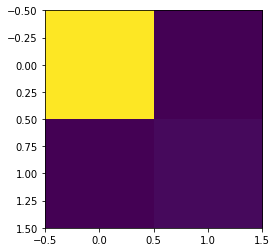

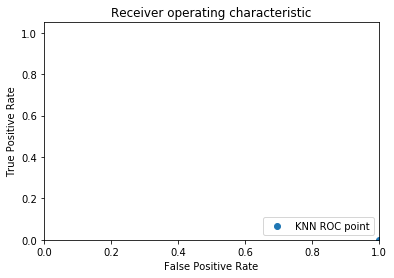

For k value,  5 :  96.67367999198477 	Test Set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19441
           1       0.37      0.38      0.37       521

   micro avg       0.97      0.97      0.97     19962
   macro avg       0.67      0.68      0.68     19962
weighted avg       0.97      0.97      0.97     19962



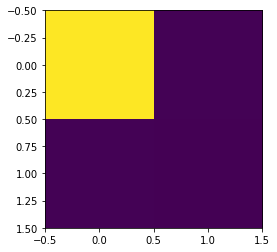

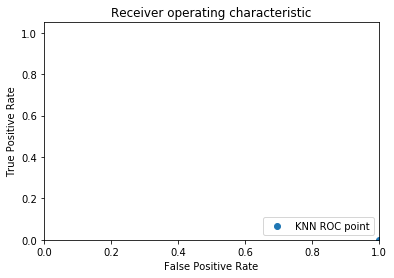

In [41]:
###### Task 3.2 and 3.3 ######
main(os.path.join(os.getcwd(), "Set-A.X.csv"),os.path.join(os.getcwd(), "Set-A.y.csv"), 5, test_size=0.8)
main(os.path.join(os.getcwd(), "Set-B.X.csv"),os.path.join(os.getcwd(), "Set-B.y.csv"), 5, test_size=0.8)

###### Task 3.4 ######
The model appears to have similar behavior between train and test sets, so it doesn't suggest overfitting. Again, the issue stems more from the imbalance in the dataset, so it becomes difficult to diagnose other issues when one issue is overshadowing any other quirks in the training. 

###### Task 4.1 ######
Based on the confusion matrices, classification report (precision, recall, F1), I would recommend Naive Bayes from the three classifiers built in the previous tasks. Naive Bayes is able to predict the legitimate customers with a high train accuracy, but most importantly, with a test accuracy that remains within a couple points of train accuracy. This means the model is trained pretty well to generalize in guessing which customers are legitimate.

###### 4.2 ######
Based on the confusion matrices, classification report (precision, recall, F1), I would recommend KNN from the three classifiers as the best of the three to classify fradulent and legitimate customers, especially when it comes to false alarms. KNN doesn't seem to suffer from the class imbalance as much as Naive Bayes or Logistic Regression and is able to classify the so-called outliers (fraudulent) customers more easily. 

###### 4.3 ######
Again, out of the three, I think Naive Bayes or KNN would work the best. I think a combination of the two as weak learners could be combined in an ensemble method to encourage the behaviour of predicting the legitimate customers correctly without false alarms, but at the same time, still be able to catch those fraudulent customers as those affect damages suffered by CoinBank. 